## Merge/Pull Request Checklist

* For the csv files in the **Resources** folder, dont commit the zip files or the extracted csv files.
* Make sure to restart and clear output in jupyter notebook.
* Code is documented and includes comments.
* Make sure you are working in your PythonData environment when making changes.

## Tasks and Timeline

* Update the status of the tasks on the team [Trello Board](https://trello.com/b/qjMY63WI/whos-doing-what) so we know who is working on what.

## Getting Started and Setup

* **Team Lead** for this section: Phil
* Before running these cells, you will need an API key for using YouTube API v3.
    * If you already have a Google API key, you can use that one or create a new one from the Google Cloud Console.
    * Instructions for creating an API key and enabling YouTube API v3 are in the [README file](./README.md).
    * After you have your API key, create a file called **config.py** in the project root directory (**team_hopper**) where you will add the key.
* After you have your API key set up, run the cells in this section to set up the project locally on your computer.
* Running these cells will:
    * Import the necessary dependencies, including reading the YouTube API key from the config.py file.
    * Extract the data zip files in the **Resources** folder, which contains all of the csv files needed for this project.
    * Import the csv files into this notebook.
    * Read the csv files into pandas dataframes.
* Questions or issues with the setup instructions, ask phil.


In [2]:
# Import the dependencies used for this project.
import pandas as pd
import requests
from config import youtube_api_key
from pprint import pprint
import time
from pathlib import Path
import os, zipfile
import shutil
import glob
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors
from datetime import datetime
from itertools import cycle, islice

In [3]:
# We need the country codes to instruct the YouTube API
# to return the list of video categories available in the specified country.
# These values are ISO 3166-1 alpha-2 country codes.
country_codes = ["US", "GB", "CA", "DE", "FR", "AU", "IE","IN", "JP", "KR", "MX", "RU", "ES"]

In [4]:
# Running this cell will unzip the data files in the Resources folder for you.
extension = ".zip"
extracted_dir_name = "youtube_trending"

# Get the current working directory..
# You need to be in the root directory of this project (same directory as this notebook) for this to work properly.
cwd_dir_name = os.getcwd()
print(f"The current working directory is {cwd_dir_name}.")

os.chdir("Resources") # change directory from working dir to dir with the zip file(s) .
# This should be your "Resources" folder.
dir_name = os.getcwd()
print(f"You are now in the following directory: {dir_name}.")

for item in os.listdir(dir_name): # loop through the items in the directory.
    if item.endswith(extension): # check for ".zip" extension
        if item == "youtube_trending.zip":
            extracted_dir_name = "youtube_trending"
        if item == "trending_videos_2020.zip":
            extracted_dir_name = "trending_videos_2020"
        try:
            file_name = os.path.abspath(item) # get full path of files
            zip_ref = zipfile.ZipFile(file_name) # create zipfile object
            # Check if the directory where we plan to extract the files already exists or not.
            if not os.path.exists(extracted_dir_name):
                os.mkdir(extracted_dir_name) # make a directory where the zip files will be extracted.
            unzipped_directory = os.path.join(extracted_dir_name) # reference to the directory where the zip files will be extracted.
            zip_ref.extractall(unzipped_directory) # extract file to dir
            zip_ref.close() # close file
            print(f"Successfully unzipped youtube data files into the following folder: {unzipped_directory} inside of {dir_name}.")
        except:
            print(f"Error trying to unzip youtube data file(s).")
            
# Go up one directory into the project root directory.
os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir))
print(os.path.normpath(os.getcwd() + os.sep + os.pardir))

The current working directory is /Users/BenSmethurst/Desktop/team_hopper.
You are now in the following directory: /Users/BenSmethurst/Desktop/team_hopper/Resources.
Successfully unzipped youtube data files into the following folder: youtube_trending inside of /Users/BenSmethurst/Desktop/team_hopper/Resources.
Successfully unzipped youtube data files into the following folder: trending_videos_2020 inside of /Users/BenSmethurst/Desktop/team_hopper/Resources.
/Users/BenSmethurst/Desktop


In [5]:
# Path to the csv files from the trending youtube video statistics kaggle dataset.
path_to_youtube_trending_csvs = os.path.join(".", "Resources", "youtube_trending")
all_files = glob.glob(os.path.join(path_to_youtube_trending_csvs, "*.csv"))

df_from_each_file = []

for f in all_files:
    filename = os.path.basename(f)
    df_country = pd.read_csv(f, encoding ="ISO-8859-1")
    df_country["Country"] = f"{filename[0]}{filename[1]}"
    df_from_each_file.append(df_country)

# Concantenated dataframe that contains all countries.
# Can filter list by country using the "Country" column
trending_videos_concatenated_df = pd.concat(df_from_each_file, ignore_index=True)
trending_videos_concatenated_df


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Country
0,SbOwzAl9ZfQ,17.14.11,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,24,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,False,False,False,Disfruta la presencia del Chef Torreblanca en ...,MX
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,False,False,False,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,MX
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,25,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,False,False,False,La canciÃ³n del principio se llama âEste esp...,MX
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,25,2017-11-13T03:47:10.000Z,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,https://i.ytimg.com/vi/hcY52MFWMDM/default.jpg,False,False,False,El video es de un Walmart en el pais centroame...,MX
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,26,2017-11-13T19:17:48.000Z,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,https://i.ytimg.com/vi/_OXDcGPVAa4/default.jpg,False,False,False,MI HERMANO NARRA MI RUTINA DE MAQUILLAJE\nhttp...,MX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375937,l884wKofd54,18.14.06,Enrique Iglesias - MOVE TO MIAMI (Official Vid...,EnriqueIglesiasVEVO,10,2018-05-09T07:00:01.000Z,"Enrique Iglesias feat. Pitbull|""MOVE TO MIAMI""...",25066952,268088,12783,9933,https://i.ytimg.com/vi/l884wKofd54/default.jpg,False,False,False,NEW SONG - MOVE TO MIAMI feat. Pitbull (Click ...,GB
375938,IP8k2xkhOdI,18.14.06,Jacob Sartorius - Up With It (Official Music V...,Jacob Sartorius,10,2018-05-11T17:09:16.000Z,"jacob sartorius|""jacob""|""up with it""|""jacob sa...",1492219,61998,13781,24330,https://i.ytimg.com/vi/IP8k2xkhOdI/default.jpg,False,False,False,THE OFFICIAL UP WITH IT MUSIC VIDEO!Get my new...,GB
375939,Il-an3K9pjg,18.14.06,Anne-Marie - 2002 [Official Video],Anne-Marie,10,2018-05-08T11:05:08.000Z,"anne|""marie""|""anne-marie""|""2002""|""two thousand...",29641412,394830,8892,19988,https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg,False,False,False,Get 2002 by Anne-Marie HERE â¶ http://ad.gt/2...,GB
375940,-DRsfNObKIQ,18.14.06,Eleni Foureira - Fuego - Cyprus - LIVE - First...,Eurovision Song Contest,24,2018-05-08T20:32:32.000Z,"Eurovision Song Contest|""2018""|""Lisbon""|""Cypru...",14317515,151870,45875,26766,https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg,False,False,False,Eleni Foureira represented Cyprus at the first...,GB


In [ ]:
# Run this cell to get the list of video categories from the YouTube API,
# which can be associated with youtube videos by category id.
def getVideoCategories(country_code):    
    base_url_categories = "https://www.googleapis.com/youtube/v3/videoCategories"
    part_categories = "snippet"
    query_url_categories = f"{base_url_categories}?part={part_categories}&regionCode={country_code}&key={youtube_api_key}"
    categories_response = requests.get(query_url_categories).json()
    category_items = categories_response["items"]
    categories = []
    
    for category in category_items:
        categories_dict = {}
        categories_dict["category_id"] = category["id"]
        categories_dict["channel_id"] = category["snippet"]["channelId"]
        categories_dict["title"] = category["snippet"]["title"]
        categories.append(categories_dict)
    return categories

for country in country_codes:
    categories = []
    categories = getVideoCategories(country)
    categories_df = pd.DataFrame(categories)
    output_file = f"{country}_categories.csv"
    output_dir = Path("./Resources/categories")
    output_dir.mkdir(parents=True, exist_ok=True)
    categories_df.to_csv(output_dir / output_file, index=False)

In [6]:
# Path to the csv files that list the different categories.
path_to_categories_csvs = os.path.join(".", "Resources", "categories")
all_category_files = glob.glob(os.path.join(path_to_categories_csvs, "*.csv"))

df_from_each_categories_file = []

for f in all_category_files:
    filename = os.path.basename(f)
    df_categories = pd.read_csv(f, encoding ="ISO-8859-1")
    df_categories["Country"] = f"{filename[0]}{filename[1]}"
    df_from_each_categories_file.append(df_categories)

# Concantenated dataframe that contains all categories
# Can filter list by country using the "Country" column
categories_concatenated_df = pd.concat(df_from_each_categories_file, ignore_index=True)

# Merge the dataframe of trending videos with the dataframe of categories on category_id and on country.
merged_trending_df = pd.merge(trending_videos_concatenated_df, categories_concatenated_df,  how='left', left_on=['category_id','Country'], right_on = ['category_id','Country'], suffixes=("_video", "_category"))

merged_trending_df

,video_id,trending_date,title_video,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Country,channel_id,title_category
0,SbOwzAl9ZfQ,17.14.11,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,24,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,False,False,False,Disfruta la presencia del Chef Torreblanca en ...,MX,UCBR8-60-B28hp2BmDPdntcQ,Entertainment
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,False,False,False,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,MX,UCBR8-60-B28hp2BmDPdntcQ,People & Blogs
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,25,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,False,False,False,La canciÃ³n del principio se llama âEste esp...,MX,UCBR8-60-B28hp2BmDPdntcQ,News & Politics
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,25,2017-11-13T03:47:10.000Z,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,https://i.ytimg.com/vi/hcY52MFWMDM/default.jpg,False,False,False,El video es de un Walmart en el pais centroame...,MX,UCBR8-60-B28hp2BmDPdntcQ,News & Politics
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,26,2017-11-13T19:17:48.000Z,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,https://i.ytimg.com/vi/_OXDcGPVAa4/default.jpg,False,False,False,MI HERMANO NARRA MI RUTINA DE MAQUILLAJE\nhttp...,MX,UCBR8-60-B28hp2BmDPdntcQ,Howto & Style
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375937,l884wKofd54,18.14.06,Enrique Iglesias - MOVE TO MIAMI (Official Vid...,EnriqueIglesiasVEVO,10,2018-05-09T07:00:01.000Z,"Enrique Iglesias feat. Pitbull|""MOVE TO MIAMI""...",25066952,268088,12783,9933,https://i.ytimg.com/vi/l884wKofd54/default.jpg,False,False,False,NEW SONG - MOVE TO MIAMI feat. Pitbull (Click ...,GB,UCBR8-60-B28hp2BmDPdntcQ,Music
375938,IP8k2xkhOdI,18.14.06,Jacob Sartorius - Up With It (Official Music V...,Jacob Sartorius,10,2018-05-11T17:09:16.000Z,"jacob sartorius|""jacob""|""up with it""|""jacob sa...",1492219,61998,13781,24330,https://i.ytimg.com/vi/IP8k2xkhOdI/default.jpg,False,False,False,THE OFFICIAL UP WITH IT MUSIC VIDEO!Get my new...,GB,UCBR8-60-B28hp2BmDPdntcQ,Music
375939,Il-an3K9pjg,18.14.06,Anne-Marie - 2002 [Official Video],Anne-Marie,10,2018-05-08T11:05:08.000Z,"anne|""marie""|""anne-marie""|""2002""|""two thousand...",29641412,394830,8892,19988,https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg,False,False,False,Get 2002 by Anne-Marie HERE â¶ http://ad.gt/2...,GB,UCBR8-60-B28hp2BmDPdntcQ,Music
375940,-DRsfNObKIQ,18.14.06,Eleni Foureira - Fuego - Cyprus - LIVE - First...,Eurovision Song Contest,24,2018-05-08T20:32:32.000Z,"Eurovision Song Contest|""2018""|""Lisbon""|""Cypru...",14317515,151870,45875,26766,https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg,False,False,False,Eleni Foureira represented Cyprus at the first...,GB,UCBR8-60-B28hp2BmDPdntcQ,Entertainment


In [7]:
# These csv files are YouTube's most popular videos for 2020.

# Path to the csv files.
path_to_trending_2020_csvs = os.path.join(".", "Resources", "trending_videos_2020")
all_files_2020 = glob.glob(os.path.join(path_to_trending_2020_csvs, "*.csv"))

df_from_each_file_2020 = []

for f in all_files_2020:
    filename = os.path.basename(f)
    df_country = pd.read_csv(f, encoding ="ISO-8859-1")
    df_country["Country"] = f"{filename[0]}{filename[1]}"
    df_from_each_file_2020.append(df_country)

# Concantenated dataframe that contains all countries.
# Can filter list by country using the "Country" column
trending_2020_concatenated_df = pd.concat(df_from_each_file_2020, ignore_index=True)
trending_2020_concatenated_df

,video_id,trending_date,duration,captions_available,title,description,publish_time,category_id,channel_id,channel_title,...,live_broadcast_content,tags,thumbnail_link,comments_disabled,comment_count,dislikes,likes,favorites,views,Country
0,zDTZcMFG6PY,20.19.01,PT2M1S,False,ÐÐ¾Ð¹ ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð¿ÑÐ¾ÑÐ...,ÐÐ¾Ð¹ ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð¿ÑÐ¾ÑÐ...,2020-01-19T07:23:15.000Z,17,UCkrbi2bmw7DQuuC8k4TP-QA,TRUE GYM,...,none,['ÐºÐ¾Ð½Ð¾Ñ Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð´Ð¾Ð½Ð°Ð»ÑÐ´...,https://i.ytimg.com/vi/zDTZcMFG6PY/default.jpg,False,10341,6365,65154,0,3867833,RU
1,ZPDUC4NlYmI,20.19.01,PT4M50S,False,UFC 246: ÐÐ°ÐºÐÑÐµÐ³Ð¾Ñ vs ÐÐ¾Ð²Ð±Ð¾Ð¹ - ...,ÐÐ¾Ð´Ð¿Ð¸ÑÑÐ²Ð°Ð¹ÑÐµÑÑ Ð½Ð° ÐµÐ´Ð¸Ð½ÑÑ...,2020-01-19T06:26:30.000Z,17,UCU8bQExxd38i-mnn-GLOtfA,UFC Russia,...,none,"['ufc', 'ufc246', 'ÐºÐ¾Ð½Ð¾Ñ', 'Ð¼Ð°ÐºÐ³ÑÐµÐ...",https://i.ytimg.com/vi/ZPDUC4NlYmI/default.jpg,False,8917,5105,71099,0,4241408,RU
2,DiA8nUi0v6Y,20.19.01,PT17M38S,False,ÐÐÐ ÐÐÐÐÐ ÐÐÐÐ vs Ð¡ÐÐ Ð ÐÐÐ: Ð...,ÐÐ°ÑÐ°Ð¹ Raid: Shadow Legends Ð±ÐµÑÐ¿Ð»Ð°Ñ...,2020-01-19T14:52:57.000Z,22,UCNb2BkmQu3IfQVcaPExHkvQ,SOBOLEV,...,none,"['Ð±Ð¾Ð¹ Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ', 'Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð...",https://i.ytimg.com/vi/DiA8nUi0v6Y/default.jpg,False,4253,13088,85400,0,1036632,RU
3,CtxzuFm3BUg,20.19.01,PT3M6S,False,ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐÑÐµÐ³Ð¾Ñ vs ÐÐ¾Ð½Ð°Ð»ÑÐ...,âºÐÐ ÐÐÐÐÐÐ - KRASSBOX\r\nâ½ KrassFoo...,2020-01-19T06:13:49.000Z,17,UCyjp_5Rp6jNvFtBE3gEX2ow,KrassboX,...,none,"['Ð±Ð¾ÐºÑ', 'Ð½Ð¾Ð²Ð¾ÑÑÐ¸ Ð±Ð¾ÐºÑÐ°', 'ufc...",https://i.ytimg.com/vi/CtxzuFm3BUg/default.jpg,False,2668,3068,15266,0,1871264,RU
4,9Umzyzj1KhU,20.19.01,PT3M3S,False,ÐÐ¾Ð¹ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ-Ð¡ÐµÑÑÐ¾Ð½Ðµ: ÐÐ±...,ÐÐ±Ð·Ð¾Ñ UFC 246: ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ-Ð¡ÐµÑÑ...,2020-01-19T13:40:11.000Z,17,UCroAB1gAyQEpk1EDUPE65QA,FightSpace,...,none,"['Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ ÑÐµÑÑÐ¾Ð½Ðµ Ð±Ð¾Ð¹', '...",https://i.ytimg.com/vi/9Umzyzj1KhU/default.jpg,False,173,767,1614,0,316964,RU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6838,yUL5Lp5aPas,20.21.01,PT5M14S,False,This Little Trick Keeps Netflix Running - Kube...,Thanks to IBM for sponsoring this video! Exper...,2020-01-12T18:22:25.000Z,28,UC0vBXGSyV14uvJ4hECDOl0Q,Techquickie,...,none,[],https://i.ytimg.com/vi/yUL5Lp5aPas/default.jpg,False,1301,2301,24067,0,505678,GB
6839,it7DoYVgrdA,20.21.01,PT14M49S,False,CRAZIEST Celeb Encounters at Bondi Beach,We take a look at some of the craziest and fun...,2020-01-11T21:00:06.000Z,24,UCxEct2HUBYj_mt4t7qR9UYg,BondiRescue,...,none,"['bondi rescue', 'bondi rescue official', 'bon...",https://i.ytimg.com/vi/it7DoYVgrdA/default.jpg,False,584,188,11221,0,753930,GB
6840,S6CIv1nxzMQ,20.21.01,PT4M19S,False,Kim Helps Former Inmate To Remove His Face Tat...,Watch All Your Favourite Reality Shows Here: h...,2020-01-12T09:30:01.000Z,24,UCn3jIZe_5xsAgo5FlvyYCXw,hayu,...,none,"['hayu', 'keeping up with the kardashians', 'r...",https://i.ytimg.com/vi/S6CIv1nxzMQ/default.jpg,False,720,260,12953,0,898395,GB
6841,l0U7SxXHkPY,20.21.01,PT5M36S,False,Future - Life Is Good (Official Music Video) f...,"""Life is Good"" available at: https://smarturl....",2020-01-10T05:00:08.000Z,10,UCFNosi99Sp0_eLilBiXmmXA,FutureVEVO,...,none,"['future', 'drake', 'hip hop', 'travis scott',...",https://i.ytimg.com/vi/l0U7SxXHkPY/default.jpg,False,51285,36564,1257090,0,45489526,GB


In [8]:
# Path to the csv files that list the different categories.
path_to_categories_csvs = os.path.join(".", "Resources", "categories")
all_category_files = glob.glob(os.path.join(path_to_categories_csvs, "*.csv"))

df_from_each_categories_file = []

for f in all_category_files:
    filename = os.path.basename(f)
    df_categories = pd.read_csv(f, encoding ="ISO-8859-1")
    df_categories["Country"] = f"{filename[0]}{filename[1]}"
    df_from_each_categories_file.append(df_categories)

# Concantenated dataframe that contains all categories
# Can filter list by country using the "Country" column
categories_concatenated_df = pd.concat(df_from_each_categories_file, ignore_index=True)

# Merge the dataframe of trending videos with the dataframe of categories on category_id and on country.
merged_trending_2020_df = pd.merge(trending_2020_concatenated_df, categories_concatenated_df,  how='left', left_on=['category_id','Country'], right_on = ['category_id','Country'], suffixes=("_video", "_category"))

merged_trending_2020_df

,video_id,trending_date,duration,captions_available,title_video,description,publish_time,category_id,channel_id_video,channel_title,...,thumbnail_link,comments_disabled,comment_count,dislikes,likes,favorites,views,Country,channel_id_category,title_category
0,zDTZcMFG6PY,20.19.01,PT2M1S,False,ÐÐ¾Ð¹ ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð¿ÑÐ¾ÑÐ...,ÐÐ¾Ð¹ ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð¿ÑÐ¾ÑÐ...,2020-01-19T07:23:15.000Z,17,UCkrbi2bmw7DQuuC8k4TP-QA,TRUE GYM,...,https://i.ytimg.com/vi/zDTZcMFG6PY/default.jpg,False,10341,6365,65154,0,3867833,RU,UCBR8-60-B28hp2BmDPdntcQ,Sports
1,ZPDUC4NlYmI,20.19.01,PT4M50S,False,UFC 246: ÐÐ°ÐºÐÑÐµÐ³Ð¾Ñ vs ÐÐ¾Ð²Ð±Ð¾Ð¹ - ...,ÐÐ¾Ð´Ð¿Ð¸ÑÑÐ²Ð°Ð¹ÑÐµÑÑ Ð½Ð° ÐµÐ´Ð¸Ð½ÑÑ...,2020-01-19T06:26:30.000Z,17,UCU8bQExxd38i-mnn-GLOtfA,UFC Russia,...,https://i.ytimg.com/vi/ZPDUC4NlYmI/default.jpg,False,8917,5105,71099,0,4241408,RU,UCBR8-60-B28hp2BmDPdntcQ,Sports
2,DiA8nUi0v6Y,20.19.01,PT17M38S,False,ÐÐÐ ÐÐÐÐÐ ÐÐÐÐ vs Ð¡ÐÐ Ð ÐÐÐ: Ð...,ÐÐ°ÑÐ°Ð¹ Raid: Shadow Legends Ð±ÐµÑÐ¿Ð»Ð°Ñ...,2020-01-19T14:52:57.000Z,22,UCNb2BkmQu3IfQVcaPExHkvQ,SOBOLEV,...,https://i.ytimg.com/vi/DiA8nUi0v6Y/default.jpg,False,4253,13088,85400,0,1036632,RU,UCBR8-60-B28hp2BmDPdntcQ,People & Blogs
3,CtxzuFm3BUg,20.19.01,PT3M6S,False,ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐÑÐµÐ³Ð¾Ñ vs ÐÐ¾Ð½Ð°Ð»ÑÐ...,âºÐÐ ÐÐÐÐÐÐ - KRASSBOX\r\nâ½ KrassFoo...,2020-01-19T06:13:49.000Z,17,UCyjp_5Rp6jNvFtBE3gEX2ow,KrassboX,...,https://i.ytimg.com/vi/CtxzuFm3BUg/default.jpg,False,2668,3068,15266,0,1871264,RU,UCBR8-60-B28hp2BmDPdntcQ,Sports
4,9Umzyzj1KhU,20.19.01,PT3M3S,False,ÐÐ¾Ð¹ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ-Ð¡ÐµÑÑÐ¾Ð½Ðµ: ÐÐ±...,ÐÐ±Ð·Ð¾Ñ UFC 246: ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ-Ð¡ÐµÑÑ...,2020-01-19T13:40:11.000Z,17,UCroAB1gAyQEpk1EDUPE65QA,FightSpace,...,https://i.ytimg.com/vi/9Umzyzj1KhU/default.jpg,False,173,767,1614,0,316964,RU,UCBR8-60-B28hp2BmDPdntcQ,Sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6838,yUL5Lp5aPas,20.21.01,PT5M14S,False,This Little Trick Keeps Netflix Running - Kube...,Thanks to IBM for sponsoring this video! Exper...,2020-01-12T18:22:25.000Z,28,UC0vBXGSyV14uvJ4hECDOl0Q,Techquickie,...,https://i.ytimg.com/vi/yUL5Lp5aPas/default.jpg,False,1301,2301,24067,0,505678,GB,UCBR8-60-B28hp2BmDPdntcQ,Science & Technology
6839,it7DoYVgrdA,20.21.01,PT14M49S,False,CRAZIEST Celeb Encounters at Bondi Beach,We take a look at some of the craziest and fun...,2020-01-11T21:00:06.000Z,24,UCxEct2HUBYj_mt4t7qR9UYg,BondiRescue,...,https://i.ytimg.com/vi/it7DoYVgrdA/default.jpg,False,584,188,11221,0,753930,GB,UCBR8-60-B28hp2BmDPdntcQ,Entertainment
6840,S6CIv1nxzMQ,20.21.01,PT4M19S,False,Kim Helps Former Inmate To Remove His Face Tat...,Watch All Your Favourite Reality Shows Here: h...,2020-01-12T09:30:01.000Z,24,UCn3jIZe_5xsAgo5FlvyYCXw,hayu,...,https://i.ytimg.com/vi/S6CIv1nxzMQ/default.jpg,False,720,260,12953,0,898395,GB,UCBR8-60-B28hp2BmDPdntcQ,Entertainment
6841,l0U7SxXHkPY,20.21.01,PT5M36S,False,Future - Life Is Good (Official Music Video) f...,"""Life is Good"" available at: https://smarturl....",2020-01-10T05:00:08.000Z,10,UCFNosi99Sp0_eLilBiXmmXA,FutureVEVO,...,https://i.ytimg.com/vi/l0U7SxXHkPY/default.jpg,False,51285,36564,1257090,0,45489526,GB,UCBR8-60-B28hp2BmDPdntcQ,Music


## Retrieving a list of YouTube's most popular videos

* The following function retrieves a list of YouTube's most popular videos using version 3 of the YouTube API.
* The API is updated daily to return the list of trending videos, which can be found on YouTube's site [here](https://www.youtube.com/feed/trending).
* The function takes a country code as input, which identifies the country for which you are retrieving videos.

In [ ]:
def getTrendingVideos(country_code):
    # The base api url for the youtube data api.
    base_url = "https://www.googleapis.com/youtube/v3/videos"

    # The page token identifies a specific page the API should return.
    next_page_token="&"

    # Comma separated list of one or more video resource properties that the API response will include.
    part = "snippet,contentDetails,statistics"

    # The chart that you want to retrieve.
    # mostPopular - returns the most popular (trending) videos.
    chart = "mostPopular"

    # The max results that should be returned in the list. Can return up to 50 results per page.
    max_results = 50

    # Create variable to store list of trending videos.
    videos = []

    while next_page_token is not None:
        print(f"One sec... getting trending videos for {country_code}....")
        query_url = f"{base_url}?part={part}{next_page_token}chart={chart}&key={youtube_api_key}&maxResults={max_results}&regionCode={country_code}"
        trending_videos_response = requests.get(query_url).json()
        trending_videos = trending_videos_response["items"]
        for video in trending_videos:
            snippet = video["snippet"]
            contentDetails = video["contentDetails"]
            statistics = video["statistics"]

            video_dict = {}

             # Fetch the id of the video.
            video_dict["video_id"] = video["id"]

            # The date the video was on youtube's trending list.
            video_dict["trending_date"] = time.strftime("%y.%d.%m")

            # Fetch video content details
            # duration - the property value is an ISO 8601 duration. 
            video_dict["duration"] = contentDetails["duration"]
            video_dict["captions_available"] = contentDetails["caption"]

            # Fetch basic details about the video (snippet).
            video_dict["title"] = snippet["title"]
            video_dict["description"] = snippet["description"]
            video_dict["publish_time"] = snippet["publishedAt"]
            video_dict["category_id"] = snippet["categoryId"]
            video_dict["channel_id"] = snippet["channelId"]
            video_dict["channel_title"] = snippet["channelTitle"]
            video_dict["localized_description"] = snippet["localized"]["description"]
            video_dict["localized_title"] = snippet["localized"]["title"]
            video_dict["live_broadcast_content"] = snippet["liveBroadcastContent"]
            try:
                video_dict["tags"] = snippet["tags"]
            except KeyError:
                video_dict["tags"] = []
            video_dict["thumbnail_link"] = snippet["thumbnails"]["default"]["url"]

            # Fetch video statistics.
            video_dict["comments_disabled"] = False
            try:
                video_dict["comment_count"] = statistics["commentCount"]
            except KeyError:
                video_dict["comment_count"] = 0
                video_dict["comments_disabled"] = True
            ratings_disabled = False
            try:
                video_dict["dislikes"] = statistics["dislikeCount"] 
                video_dict["likes"] = statistics["likeCount"]
            except KeyError:
                video_dict["dislikes"] = 0
                video_dict["likes"] = 0
                ratings_disabled = True
            video_dict["favorites"] = statistics["favoriteCount"]    
            video_dict["views"] = statistics["viewCount"]

            videos.append(video_dict)

        # Check the nextPageToken on the API response to see if there is another page to fetch data from.
        try:
            next_page_token = trending_videos_response["nextPageToken"]
            next_page_token = f"&pageToken={next_page_token}&"
        except KeyError:
            next_page_token = None
            
    return videos

In [9]:
# Running this cell retrieves the most popular videos for each country using the YouTube API and stores the output
# in the Resources folder.
# You do NOT need to run this cell.
for country in country_codes:
    country_videos = []
    country_videos = getTrendingVideos(country)
    country_videos_df = pd.DataFrame(country_videos)
    # Leave the below lines commented out.
    # output_file = f"{country}_videos.csv"
    # output_dir = Path("./Resources/trending_videos_2020")
    # output_dir.mkdir(parents=True, exist_ok=True)
    # country_videos_df.to_csv(output_dir / output_file, index=False, header=False, mode="a")

country_videos_df.head()

NameError: name 'getTrendingVideos' is not defined

In [ ]:
# This cell zips up the csv data files in "Resources/trending_videos_2020"
# You do NOT need to run this.
# dir_name = Path("./Resources/trending_videos_2020")
# shutil.make_archive("./Resources/trending_videos_2020", 'zip', dir_name)

## Clean the Data

* **Team Lead** for this section: Jenna
* Check for null/na values. Remove (if necessary).
* Rename columns to be something more meaningful (remove underscores from column names).
    * For example, change "category_id" to "Category ID".
* Remove unnecessary columns.
* As an additional resource, check out [this file](https://umn.bootcampcontent.com/University-of-Minnesota-Boot-Camp/UofM-STP-DATA-PT-11-2019-U-C/blob/master/04-Pandas/Activities/2019-12-16_and_17_Pandas_lesson_2/03-Ins_CleaningData/Solved/CleaningData.ipynb).
* Do anything else that you think will make the data easy to work with.

In [10]:
clean_trending_df = merged_trending_df[['video_id', 'trending_date', 'title_video', 'channel_title', 
                                        'publish_time', 'tags', 'views', 'likes', 'dislikes', "comment_count",
                                        'Country', 'title_category']]
clean_trending_df.head()

,video_id,trending_date,title_video,channel_title,publish_time,tags,views,likes,dislikes,comment_count,Country,title_category
0,SbOwzAl9ZfQ,17.14.11,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,MX,Entertainment
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,MX,People & Blogs
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,MX,News & Politics
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,2017-11-13T03:47:10.000Z,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,MX,News & Politics
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,2017-11-13T19:17:48.000Z,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,MX,Howto & Style


In [11]:
clean_trending_df = clean_trending_df.rename(columns = 
                                             {"video_id": "Video ID", 
                                              "trending_date": "Trending Date",
                                             "title_video": "Video Title", 
                                             "channel_title":"Channel Title", 
                                             "publish_time": "Publish Time",
                                             "tags": "Tags",
                                             "views": "Views", 
                                              "likes": "Likes",
                                             "dislikes": "Dislikes",
                                             "comment_count": "Comment Count",
                                             "description": "Description", 
                                             "title_category": "Category"})
clean_trending_df.head()

,Video ID,Trending Date,Video Title,Channel Title,Publish Time,Tags,Views,Likes,Dislikes,Comment Count,Country,Category
0,SbOwzAl9ZfQ,17.14.11,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,MX,Entertainment
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,MX,People & Blogs
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,MX,News & Politics
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,2017-11-13T03:47:10.000Z,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,MX,News & Politics
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,2017-11-13T19:17:48.000Z,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,MX,Howto & Style


In [12]:
#look for N/As
clean_trending_df.count()

Video ID         375942
Trending Date    375942
Video Title      375942
Channel Title    375942
Publish Time     375942
Tags             375942
Views            375942
Likes            375942
Dislikes         375942
Comment Count    375942
Country          375942
Category         373204
dtype: int64

In [13]:
#clean_trending_df['Category'].unique()
#if time figure out what nan is
clean_trending_df.dropna(how='any')


,Video ID,Trending Date,Video Title,Channel Title,Publish Time,Tags,Views,Likes,Dislikes,Comment Count,Country,Category
0,SbOwzAl9ZfQ,17.14.11,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,MX,Entertainment
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,MX,People & Blogs
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,MX,News & Politics
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,2017-11-13T03:47:10.000Z,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,MX,News & Politics
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,2017-11-13T19:17:48.000Z,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,MX,Howto & Style
...,...,...,...,...,...,...,...,...,...,...,...,...
375937,l884wKofd54,18.14.06,Enrique Iglesias - MOVE TO MIAMI (Official Vid...,EnriqueIglesiasVEVO,2018-05-09T07:00:01.000Z,"Enrique Iglesias feat. Pitbull|""MOVE TO MIAMI""...",25066952,268088,12783,9933,GB,Music
375938,IP8k2xkhOdI,18.14.06,Jacob Sartorius - Up With It (Official Music V...,Jacob Sartorius,2018-05-11T17:09:16.000Z,"jacob sartorius|""jacob""|""up with it""|""jacob sa...",1492219,61998,13781,24330,GB,Music
375939,Il-an3K9pjg,18.14.06,Anne-Marie - 2002 [Official Video],Anne-Marie,2018-05-08T11:05:08.000Z,"anne|""marie""|""anne-marie""|""2002""|""two thousand...",29641412,394830,8892,19988,GB,Music
375940,-DRsfNObKIQ,18.14.06,Eleni Foureira - Fuego - Cyprus - LIVE - First...,Eurovision Song Contest,2018-05-08T20:32:32.000Z,"Eurovision Song Contest|""2018""|""Lisbon""|""Cypru...",14317515,151870,45875,26766,GB,Entertainment


In [14]:
clean_trending_df['Category'].unique()

array(['Entertainment', 'People & Blogs', 'News & Politics',
       'Howto & Style', 'Music', 'Comedy', 'Sports', 'Autos & Vehicles',
       'Film & Animation', nan, 'Education', 'Science & Technology',
       'Gaming', 'Pets & Animals', 'Travel & Events', 'Shows', 'Movies',
       'Trailers', 'Nonprofits & Activism'], dtype=object)

In [15]:
categories_concatenated_df['title'].unique()

array(['Film & Animation', 'Autos & Vehicles', 'Music', 'Pets & Animals',
       'Sports', 'Short Movies', 'Travel & Events', 'Gaming',
       'Videoblogging', 'People & Blogs', 'Comedy', 'Entertainment',
       'News & Politics', 'Howto & Style', 'Education',
       'Science & Technology', 'Movies', 'Anime/Animation',
       'Action/Adventure', 'Classics', 'Documentary', 'Drama', 'Family',
       'Foreign', 'Horror', 'Sci-Fi/Fantasy', 'Thriller', 'Shorts',
       'Shows', 'Trailers', 'Nonprofits & Activism'], dtype=object)

In [16]:
#Clean 2020 merged data
clean_trending2020_df = merged_trending_2020_df[
                                        ['video_id', 'trending_date', 'duration', 'title_video', 'channel_title', 
                                        'publish_time', 'tags', 'views', 'likes', 'dislikes', 
                                        'Country', 'title_category','comment_count']]
clean_trending2020_df.head()

,video_id,trending_date,duration,title_video,channel_title,publish_time,tags,views,likes,dislikes,Country,title_category,comment_count
0,zDTZcMFG6PY,20.19.01,PT2M1S,ÐÐ¾Ð¹ ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð¿ÑÐ¾ÑÐ...,TRUE GYM,2020-01-19T07:23:15.000Z,['ÐºÐ¾Ð½Ð¾Ñ Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð´Ð¾Ð½Ð°Ð»ÑÐ´...,3867833,65154,6365,RU,Sports,10341
1,ZPDUC4NlYmI,20.19.01,PT4M50S,UFC 246: ÐÐ°ÐºÐÑÐµÐ³Ð¾Ñ vs ÐÐ¾Ð²Ð±Ð¾Ð¹ - ...,UFC Russia,2020-01-19T06:26:30.000Z,"['ufc', 'ufc246', 'ÐºÐ¾Ð½Ð¾Ñ', 'Ð¼Ð°ÐºÐ³ÑÐµÐ...",4241408,71099,5105,RU,Sports,8917
2,DiA8nUi0v6Y,20.19.01,PT17M38S,ÐÐÐ ÐÐÐÐÐ ÐÐÐÐ vs Ð¡ÐÐ Ð ÐÐÐ: Ð...,SOBOLEV,2020-01-19T14:52:57.000Z,"['Ð±Ð¾Ð¹ Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ', 'Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð...",1036632,85400,13088,RU,People & Blogs,4253
3,CtxzuFm3BUg,20.19.01,PT3M6S,ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐÑÐµÐ³Ð¾Ñ vs ÐÐ¾Ð½Ð°Ð»ÑÐ...,KrassboX,2020-01-19T06:13:49.000Z,"['Ð±Ð¾ÐºÑ', 'Ð½Ð¾Ð²Ð¾ÑÑÐ¸ Ð±Ð¾ÐºÑÐ°', 'ufc...",1871264,15266,3068,RU,Sports,2668
4,9Umzyzj1KhU,20.19.01,PT3M3S,ÐÐ¾Ð¹ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ-Ð¡ÐµÑÑÐ¾Ð½Ðµ: ÐÐ±...,FightSpace,2020-01-19T13:40:11.000Z,"['Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ ÑÐµÑÑÐ¾Ð½Ðµ Ð±Ð¾Ð¹', '...",316964,1614,767,RU,Sports,173


In [17]:
#Rename the 2020 merged data 
clean_trending_2020_df = clean_trending2020_df.rename(columns = 
                                             {"video_id": "Video ID", 
                                              "trending_date": "Trending Date",
                                              "duration": "Duration",
                                             "title_video": "Video Title", 
                                             "channel_title":"Channel Title", 
                                             "publish_time": "Publish Time",
                                             "tags": "Tags",
                                             "views": "Views", 
                                              "likes": "Likes",
                                             "dislikes": "Dislikes",
                                             "description": "Description", 
                                             "title_category": "Category",
                                             "comment_count":"Comment Count"})
clean_trending_2020_df.head()

,Video ID,Trending Date,Duration,Video Title,Channel Title,Publish Time,Tags,Views,Likes,Dislikes,Country,Category,Comment Count
0,zDTZcMFG6PY,20.19.01,PT2M1S,ÐÐ¾Ð¹ ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð¿ÑÐ¾ÑÐ...,TRUE GYM,2020-01-19T07:23:15.000Z,['ÐºÐ¾Ð½Ð¾Ñ Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð´Ð¾Ð½Ð°Ð»ÑÐ´...,3867833,65154,6365,RU,Sports,10341
1,ZPDUC4NlYmI,20.19.01,PT4M50S,UFC 246: ÐÐ°ÐºÐÑÐµÐ³Ð¾Ñ vs ÐÐ¾Ð²Ð±Ð¾Ð¹ - ...,UFC Russia,2020-01-19T06:26:30.000Z,"['ufc', 'ufc246', 'ÐºÐ¾Ð½Ð¾Ñ', 'Ð¼Ð°ÐºÐ³ÑÐµÐ...",4241408,71099,5105,RU,Sports,8917
2,DiA8nUi0v6Y,20.19.01,PT17M38S,ÐÐÐ ÐÐÐÐÐ ÐÐÐÐ vs Ð¡ÐÐ Ð ÐÐÐ: Ð...,SOBOLEV,2020-01-19T14:52:57.000Z,"['Ð±Ð¾Ð¹ Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ', 'Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð...",1036632,85400,13088,RU,People & Blogs,4253
3,CtxzuFm3BUg,20.19.01,PT3M6S,ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐÑÐµÐ³Ð¾Ñ vs ÐÐ¾Ð½Ð°Ð»ÑÐ...,KrassboX,2020-01-19T06:13:49.000Z,"['Ð±Ð¾ÐºÑ', 'Ð½Ð¾Ð²Ð¾ÑÑÐ¸ Ð±Ð¾ÐºÑÐ°', 'ufc...",1871264,15266,3068,RU,Sports,2668
4,9Umzyzj1KhU,20.19.01,PT3M3S,ÐÐ¾Ð¹ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ-Ð¡ÐµÑÑÐ¾Ð½Ðµ: ÐÐ±...,FightSpace,2020-01-19T13:40:11.000Z,"['Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ ÑÐµÑÑÐ¾Ð½Ðµ Ð±Ð¾Ð¹', '...",316964,1614,767,RU,Sports,173


In [18]:
#Look for NAN 
clean_trending_2020_df.count()

Video ID         6843
Trending Date    6843
Duration         6843
Video Title      6843
Channel Title    6843
Publish Time     6843
Tags             6843
Views            6843
Likes            6843
Dislikes         6843
Country          6843
Category         6827
Comment Count    6843
dtype: int64

In [19]:
#Drop NAN
clean_trending_2020_df.dropna(how='any')

,Video ID,Trending Date,Duration,Video Title,Channel Title,Publish Time,Tags,Views,Likes,Dislikes,Country,Category,Comment Count
0,zDTZcMFG6PY,20.19.01,PT2M1S,ÐÐ¾Ð¹ ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð¿ÑÐ¾ÑÐ...,TRUE GYM,2020-01-19T07:23:15.000Z,['ÐºÐ¾Ð½Ð¾Ñ Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ Ð´Ð¾Ð½Ð°Ð»ÑÐ´...,3867833,65154,6365,RU,Sports,10341
1,ZPDUC4NlYmI,20.19.01,PT4M50S,UFC 246: ÐÐ°ÐºÐÑÐµÐ³Ð¾Ñ vs ÐÐ¾Ð²Ð±Ð¾Ð¹ - ...,UFC Russia,2020-01-19T06:26:30.000Z,"['ufc', 'ufc246', 'ÐºÐ¾Ð½Ð¾Ñ', 'Ð¼Ð°ÐºÐ³ÑÐµÐ...",4241408,71099,5105,RU,Sports,8917
2,DiA8nUi0v6Y,20.19.01,PT17M38S,ÐÐÐ ÐÐÐÐÐ ÐÐÐÐ vs Ð¡ÐÐ Ð ÐÐÐ: Ð...,SOBOLEV,2020-01-19T14:52:57.000Z,"['Ð±Ð¾Ð¹ Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ', 'Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð...",1036632,85400,13088,RU,People & Blogs,4253
3,CtxzuFm3BUg,20.19.01,PT3M6S,ÐÐ¾Ð½Ð¾Ñ ÐÐ°ÐºÐÑÐµÐ³Ð¾Ñ vs ÐÐ¾Ð½Ð°Ð»ÑÐ...,KrassboX,2020-01-19T06:13:49.000Z,"['Ð±Ð¾ÐºÑ', 'Ð½Ð¾Ð²Ð¾ÑÑÐ¸ Ð±Ð¾ÐºÑÐ°', 'ufc...",1871264,15266,3068,RU,Sports,2668
4,9Umzyzj1KhU,20.19.01,PT3M3S,ÐÐ¾Ð¹ ÐÐ°ÐºÐ³ÑÐµÐ³Ð¾Ñ-Ð¡ÐµÑÑÐ¾Ð½Ðµ: ÐÐ±...,FightSpace,2020-01-19T13:40:11.000Z,"['Ð¼Ð°ÐºÐ³ÑÐµÐ³Ð¾Ñ ÑÐµÑÑÐ¾Ð½Ðµ Ð±Ð¾Ð¹', '...",316964,1614,767,RU,Sports,173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6838,yUL5Lp5aPas,20.21.01,PT5M14S,This Little Trick Keeps Netflix Running - Kube...,Techquickie,2020-01-12T18:22:25.000Z,[],505678,24067,2301,GB,Science & Technology,1301
6839,it7DoYVgrdA,20.21.01,PT14M49S,CRAZIEST Celeb Encounters at Bondi Beach,BondiRescue,2020-01-11T21:00:06.000Z,"['bondi rescue', 'bondi rescue official', 'bon...",753930,11221,188,GB,Entertainment,584
6840,S6CIv1nxzMQ,20.21.01,PT4M19S,Kim Helps Former Inmate To Remove His Face Tat...,hayu,2020-01-12T09:30:01.000Z,"['hayu', 'keeping up with the kardashians', 'r...",898395,12953,260,GB,Entertainment,720
6841,l0U7SxXHkPY,20.21.01,PT5M36S,Future - Life Is Good (Official Music Video) f...,FutureVEVO,2020-01-10T05:00:08.000Z,"['future', 'drake', 'hip hop', 'travis scott',...",45489526,1257090,36564,GB,Music,51285


In [20]:
clean_trending_2020_df['Category'].unique()

array(['Sports', 'People & Blogs', 'Comedy', 'Entertainment',
       'Science & Technology', 'Film & Animation', 'News & Politics',
       'Autos & Vehicles', 'Gaming', 'Education', 'Music',
       'Howto & Style', 'Pets & Animals', nan, 'Travel & Events'],
      dtype=object)

In [21]:
clean_trending_2020_df.count()


Video ID         6843
Trending Date    6843
Duration         6843
Video Title      6843
Channel Title    6843
Publish Time     6843
Tags             6843
Views            6843
Likes            6843
Dislikes         6843
Country          6843
Category         6827
Comment Count    6843
dtype: int64

## Summary Statistics

* **Team Lead** for this section: Katrina
* Perform a .describe() on the dataframe to get some quick summary statistics.
* Calculate the mean, median, standard deviation, variance, and standard error of mean (sem) for trending videos.
  * Do this for the numeric columns: views, likes, and comments.
  * Might be also a good idea to group the dataframe by category id and calculate those same statistics.
* As an additional resource, check out [this file](https://umn.bootcampcontent.com/University-of-Minnesota-Boot-Camp/UofM-STP-DATA-PT-11-2019-U-C/blob/master/05-Matplotlib/Activities/2020-01-06_and_07_lesson_3/01-Ins_Summary_Statistics/Solved/samples.ipynb).

## What's next?

## What type of categories are more likely to make it on the trending list?

In [22]:
# Find US trending videos.
us_category_groupby_df = clean_trending_df.loc[clean_trending_df["Country"] == "US"]
# Find OUS trending videos.
ous_category_groupby_df = clean_trending_df.loc[clean_trending_df["Country"] != "US"]

# Group dataframe by category and count up number of videos.
# Use .nunique so we don't count videos more than once.
us_category_groupby_df = us_category_groupby_df.groupby(['Category'])['Video ID'].nunique().sort_values(ascending=False)
us_category_groupby_df = pd.DataFrame(us_category_groupby_df)
ous_category_groupby_df = ous_category_groupby_df.groupby(['Category'])['Video ID'].nunique().sort_values(ascending=False)
ous_category_groupby_df = pd.DataFrame(ous_category_groupby_df)

# Rename column to be something more meaningful.
us_category_groupby_df = us_category_groupby_df.rename(columns={
    "Video ID": "Number of Trending Videos"
})
ous_category_groupby_df = ous_category_groupby_df.rename(columns={
    "Video ID": "Number of Trending Videos"
})

# Get the top 5 trending categories.
top_5_categories_us = us_category_groupby_df[:5]
top_5_categories_us = pd.DataFrame(top_5_categories_us)
top_5_categories_ous = ous_category_groupby_df[:5]
top_5_categories_ous = pd.DataFrame(top_5_categories_ous)

# Get the other categories.
new_row_us = pd.DataFrame({
    'Category' : ['Others'],
    'Number of Trending Videos' : [us_category_groupby_df['Number of Trending Videos'][5:].sum()]
}).set_index("Category")
new_row_ous = pd.DataFrame({
    'Category' : ['Others'],
    'Number of Trending Videos' : [ous_category_groupby_df['Number of Trending Videos'][5:].sum()]
}).set_index("Category")

# Combined the top 5 with the others.
top_trending_categories_us = pd.concat([top_5_categories_us, new_row_us])
top_trending_categories_ous = pd.concat([top_5_categories_ous, new_row_ous])

# Print the results.
print('-------------------------------------------------------')
print('Top trending videos by category for OUS')
print(top_trending_categories_ous)
print('-------------------------------------------------------')
print('Top trending videos by category for US')
print(top_trending_categories_us)
print('-------------------------------------------------------')

-------------------------------------------------------
Top trending videos by category for OUS
                 Number of Trending Videos
Category                                  
Entertainment                        52101
People & Blogs                       32999
News & Politics                      21827
Sports                               13250
Comedy                               10526
Others                               48285
-------------------------------------------------------
Top trending videos by category for US
                 Number of Trending Videos
Category                                  
Entertainment                         1622
Music                                  801
Howto & Style                          595
Comedy                                 547
News & Politics                        507
Others                                2296
-------------------------------------------------------


## Top trending videos by category for OUS and US.

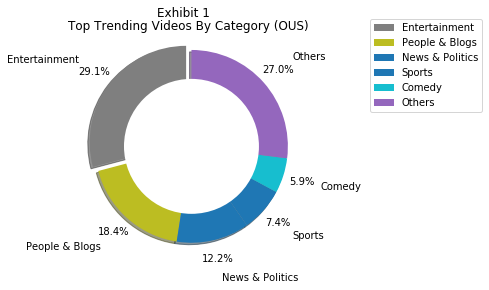

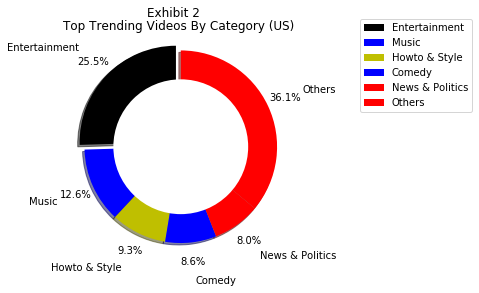

In [46]:
# Create two pie charts. One that shows the top trending videos by category for US. Other for OUS (Outside of US).
# The colors of each section of the pie chart.
# OUS
number_of_colors_ous = len(top_trending_categories_ous)
colors_ous = random.choices(list(mcolors.TABLEAU_COLORS.values()),k = number_of_colors_ous)
# US
number_of_colors_us = len(top_trending_categories_us)
colors_us = random.choices(list(mcolors.BASE_COLORS.values()),k = number_of_colors_us)

# Specify the sizes and labels for the pie chart.
# OUS
sizes_ous = list(top_trending_categories_ous.loc[:, "Number of Trending Videos"])
labels_ous = list(top_trending_categories_ous.index.values)
# US
sizes_us = list(top_trending_categories_us.loc[:, "Number of Trending Videos"])
labels_us = list(top_trending_categories_us.index.values)

# Creat plot for OUS.
plt.figure(0)

# explosion
explode = (0.07,0,0,0,0,0)

# Create pie chart.
plt.pie(sizes_ous, colors=colors_ous, labels=labels_ous, autopct='%1.1f%%', startangle=90,  pctdistance=1.2, labeldistance=1.4, explode=explode, shadow=True)

# Make a donut chart.
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal axis
plt.axis('equal') 

# Add a title.
plt.title("Top Trending Videos By Category (OUS)")
plt.suptitle("Exhibit 1")

# Add a legend.
plt.legend(bbox_to_anchor=(1.025,1.10), loc="upper left")

# Save figure
plt.savefig("./Images/top_trending_videos_by_category_ous.png", bbox_inches='tight')

# Create plot for US.
plt.figure(1)

# explosion
explode = (0.07,0,0,0,0,0)

# Create pie chart.
plt.pie(sizes_us, colors=colors_us, labels=labels_us, autopct='%1.1f%%', startangle=90,  pctdistance=1.2, labeldistance=1.4, explode=explode, shadow=True)

# Make a donut chart.
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal axis
plt.axis('equal') 

# Add a title.
plt.title("Top Trending Videos By Category (US)")
plt.suptitle("Exhibit 2")


# Add a legend.
plt.legend(bbox_to_anchor=(1.025,1.10), loc="upper left")

# Save figure
plt.savefig("./Images/top_trending_videos_by_category_us.png", bbox_inches='tight')

# Show plot
plt.show()

## Figure Analysis: Trending Videos by Category 

### Exhibit 1
 
* This figure represents which YouTube category is most popular for non-US viewers, according to the trending videos lise. As shown by the figure, the most dominant category for trending videos in countries outside of the US is the "Entertainment" category. Followed by the "People & Blogs" and "News & Politics" as the second and third most popular categories, respectively. Interestingly, there is no category that consumes the majority (50 percent or more) of the trending videos list for countries outside of the US. The figure shows a diverse collection of categories considering the addition of "Others", which includes 26 additional categories outside of teh top five displayed above in Exhibit 1.
     
### Exhibit 2

* This figure represents which YouTube category is the most popular for US viewers, according to the trending videos list. As shown by the figure, the most dominant category for trending videos in the US is the "Entertainment" category. The second and third most popular US trending video categories are "Music" and "How-to & Style", respectivly. No single category consumes the majority (50 percent or more) of the trending videos list for the US. A diverse collection of category viewership is shown in the figure with the "Others" category making up more than one third of the viewership. The "Others" category in the US includes 38 additional categories outside of the top five displayed above in Exhibit 2. 
     
**Comparitive Analysis**

* Comparing Exhibit 1 and Exhibit 2 shows that the US and other countries may have similar YouTube viewership. Most notably these figures show that the top category in the world is "Entertainment". Other categories that appear in both top five category lists are "News and Politics" and "Comedy". Another useful comparison is found in the "Others" category. Both exhibits show that more than thrity percent of viewship for trending videos comes from "Others". This shows evidence of a large variety of viewership by category across every country. 

**Considerations and Summarized Findings**

* YouTube category is selected by the video creators. Due to this, YouTube has little control over how videos are categorized by their site. As a result, certain categories may find overlap between one category and another. An example of this overlap would be between the US video categories "Videoblogging" and "People and Blogs". In future studies of YouTube trending videos, a grouping of the category list may prove to be useful and may result in a more precise look at which grouped category is the most popular among trending videos. 

* _YouTube trending video viewership is highly varied and category may not determine trending success_
* _Comparing the US and other countries shows that "Entertainment" is the most popular category worldwide_


## Does publish time affect engagement (number of likes and comments) and a video's chances of making it on the trending list?

In [24]:
# Find US countries.
us_publish_time_df = clean_trending_df.loc[clean_trending_df["Country"] == "US"]
# Find OUS countries.
ous_publish_time_df = clean_trending_df.loc[clean_trending_df["Country"] != "US"]

# Only include columns we need.
us_publish_time_df = us_publish_time_df[["Video ID", "Likes", "Comment Count", "Publish Time"]]
ous_publish_time_df = ous_publish_time_df[["Video ID", "Likes", "Comment Count", "Publish Time"]]

# Calculate total number of comments and likes for each video.
# US
total_number_likes_comments_us = (us_publish_time_df["Likes"] + us_publish_time_df["Comment Count"])
us_publish_time_df["Total Number of Likes and Comments"] = total_number_likes_comments_us
# OUS
total_number_likes_comments_ous = (ous_publish_time_df["Likes"] + ous_publish_time_df["Comment Count"])
ous_publish_time_df["Total Number of Likes and Comments"] = total_number_likes_comments_ous

# Time Conversion
# US
us_publish_time_df["Publish Time"] = pd.to_datetime(us_publish_time_df['Publish Time'], dayfirst=True).dt.strftime('%I:%M %p')
us_publish_time_df["Publish Time"] = pd.to_datetime(us_publish_time_df["Publish Time"])
# OUS
ous_publish_time_df["Publish Time"] = pd.to_datetime(ous_publish_time_df['Publish Time'], dayfirst=True).dt.strftime('%I:%M %p')
ous_publish_time_df["Publish Time"] = pd.to_datetime(ous_publish_time_df["Publish Time"])

hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
us_publish_time_df = us_publish_time_df.set_index("Publish Time")
ous_publish_time_df = ous_publish_time_df.set_index("Publish Time")

# Function to get average number of likes and comments for videos within specific ranges of time (i.e., 1 hour).
def binTime(times, df):
    number_likes_comments_time_of_day = []
    number_trending_videos_time_of_day = []
    for time in times:
        time_bin = df.between_time(f'{time}:00', f'{time}:59')
        average_comments_likes = time_bin["Total Number of Likes and Comments"].mean()
        number_trending_videos = time_bin["Video ID"].nunique()
        number_likes_comments_time_of_day.append(average_comments_likes)
        number_trending_videos_time_of_day.append(number_trending_videos)
    return number_likes_comments_time_of_day, number_trending_videos_time_of_day

us_number_likes_comments, us_trending_videos_time_of_day = binTime(hours, us_publish_time_df)
ous_number_likes_comments, ous_trending_videos_time_of_day = binTime(hours, ous_publish_time_df)

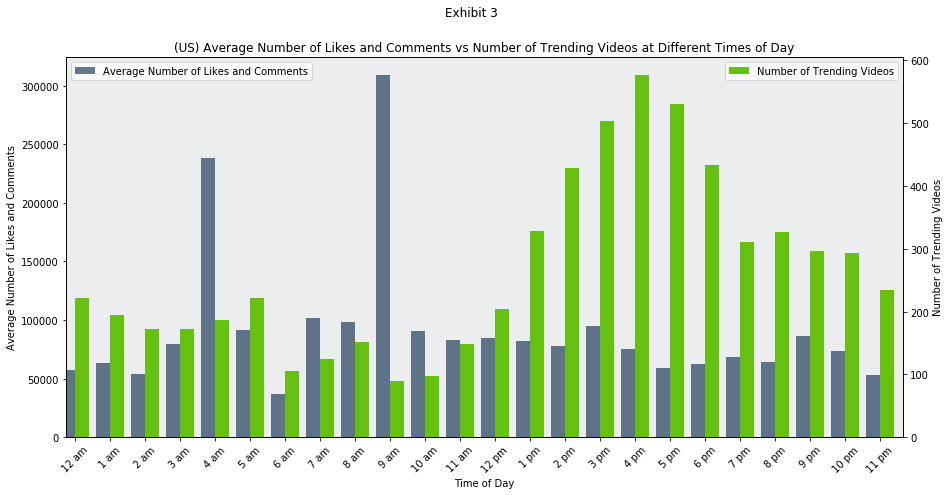

In [49]:
# Create values/bins for x-axis. X-axis labels will be hour increments.
x_axis = ['12 am', '1 am', '2 am', '3 am', '4 am', '5 am', '6 am', '7 am', '8 am',
          '9 am', '10 am', '11 am', '12 pm', '1 pm', '2 pm', '3 pm', '4 pm', '5 pm',
          '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm']

# Put time of day, average number of likes and comments, and number of trending videos into a dataframe.
us_time_of_day_df = pd.DataFrame({
    "Time of Day": x_axis,
    "Average Number of Likes and Comments": us_number_likes_comments,
    "Number of Trending Videos": us_trending_videos_time_of_day
})

# Set index to time of day (this will be the x axis).
us_time_of_day_df = us_time_of_day_df.set_index("Time of Day")

# Create matplotlib figure
fig = plt.figure()

# Create matplotlib axes
ax = fig.add_subplot(111)
# Create another axes that shares the same x-axis as ax.
ax2 = ax.twinx()

# Set the background color of the plot.
ax.set_facecolor('#A5ACAF35')

# Set the width of the bars.
width = 0.4

# Plot average number of likes and comments.
us_time_of_day_df["Average Number of Likes and Comments"].plot(kind='bar', ax=ax, width=width, position=1, figsize=(15,7), color='#002145', alpha=0.6)
# Plot number of trending videos on the same plot.
us_time_of_day_df["Number of Trending Videos"].plot(kind='bar', ax=ax2, width=width, position=0,  color='#66C010', alpha=1.0)

# Rotate the xtick labels.
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Give the plot a title.
plt.title("(US) Average Number of Likes and Comments vs Number of Trending Videos at Different Times of Day")
plt.suptitle("Exhibit 3")

# Add labels to y-axes.
ax.set_ylabel('Average Number of Likes and Comments')
ax2.set_ylabel('Number of Trending Videos')

# Add legends.
ax.legend(["Average Number of Likes and Comments"], loc="upper left");
ax2.legend(["Number of Trending Videos"], loc="upper right");

# Save figure as an image.
plt.savefig("./Images/time_of_day_us.png", bbox_inches='tight')

# Show plot
plt.show()

## Figure Analysis: Publish Time and Engagement for Trending YouTube Videos

**Exhibit 3**
 
* Exhibit 3 shows the engagement (comments, likes, and dislikes) with trending videos compared to time of day as well as the posting time of trending videos for YouTube trending videos in the US. Looking first at engagement, it is clear that the average total engement for trending videos hovers between fifty thousand and one hundred thousand for a majority of the day. Two outliers include the 4am and 9am times which show large increases in engagement averages of up to three hundred thousand at 9am. Also shown in Exhibit 3 is the number of trending videos based on their time posted. The figure shows a large number of trending videos are posted between 1pm and 10pm. 

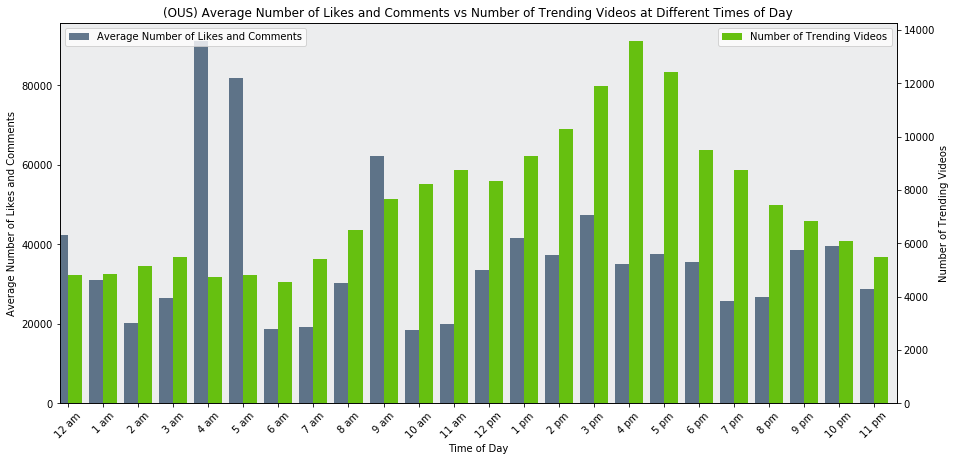

In [26]:
# Create values/bins for x-axis. X-axis labels will be hour increments.
x_axis = ['12 am', '1 am', '2 am', '3 am', '4 am', '5 am', '6 am', '7 am', '8 am',
          '9 am', '10 am', '11 am', '12 pm', '1 pm', '2 pm', '3 pm', '4 pm', '5 pm',
          '6 pm', '7 pm', '8 pm', '9 pm', '10 pm', '11 pm']

# Put time of day, average number of likes and comments, and number of trending videos into a dataframe.
ous_time_of_day_df = pd.DataFrame({
    "Time of Day": x_axis,
    "Average Number of Likes and Comments": ous_number_likes_comments,
    "Number of Trending Videos": ous_trending_videos_time_of_day
})

# Set index to time of day (this will be the x axis).
ous_time_of_day_df = ous_time_of_day_df.set_index("Time of Day")

# Create matplotlib figure
fig = plt.figure()

# Create matplotlib axes
ax = fig.add_subplot(111)
# Create another axes that shares the same x-axis as ax.
ax2 = ax.twinx()

# Set the background color of the plot.
ax.set_facecolor('#A5ACAF35')

# Set the width of the bars.
width = 0.4

# Plot average number of likes and comments.
ous_time_of_day_df["Average Number of Likes and Comments"].plot(kind='bar', ax=ax, width=width, position=1, figsize=(15,7), color='#002145', alpha=0.6)
# Plot number of trending videos on the same plot.
ous_time_of_day_df["Number of Trending Videos"].plot(kind='bar', ax=ax2, width=width, position=0,  color='#66C010', alpha=1.0)

# Rotate the xtick labels.
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Give the plot a title.
plt.title("(OUS) Average Number of Likes and Comments vs Number of Trending Videos at Different Times of Day")

# Add labels to y-axes.
ax.set_ylabel('Average Number of Likes and Comments')
ax2.set_ylabel('Number of Trending Videos')

# Add legends.
ax.legend(["Average Number of Likes and Comments"], loc="upper left");
ax2.legend(["Number of Trending Videos"], loc="upper right");

# Save figure as an image.
plt.savefig("./Images/time_of_day_ous.png", bbox_inches='tight')

# Show plot
plt.show()
